# Physics 256
## Fast Fourier Transform

<img src="https://groups.csail.mit.edu/netmit/sFFT/images/sFFT5.png" width=600px>

## Last Time

- Spectral analysis
- Discrete Fourier transform
- Nyquist frequency


## Today

- Fast Fourier transform

## Setting up the Notebook

In [97]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use('notebook');
%config InlineBackend.figure_format = 'retina'
colors = ["#2078B5", "#FF7F0F", "#2CA12C", "#D72827", "#9467BE", "#8C574B",
            "#E478C2", "#808080", "#BCBE20", "#17BED0", "#AEC8E9", "#FFBC79", 
            "#98E08B", "#FF9896", "#C6B1D6", "#C59D94", "#F8B7D3", "#C8C8C8", 
           "#DCDC8E", "#9EDAE6"]

## Discrete Fourier Transform

For a discrete time series $\vec{y}$ measured at times $t_j = j \Delta t$, the discrete Fourier transform is given by:

\begin{equation}
\hat{y}_k  = \sum_{j=0}^{N-1} y_j \mathrm{e}^{-i 2\pi k j /N} .
\end{equation}

for $k=0,\ldots,N-1$.  The minimum non-zero frequency is $\omega_{\rm min} = 2\pi/(N\Delta t)$ while the maximum frequency is given by: $\omega_{\rm Ny} = \pi/\Delta t$.

Last time we considered a *brute force* implementation of $\hat{y}_k$ that is formally of order $\mathrm{O}(N^2)$.  We have to perform $N$ summations, each containint $N$ terms.  Historically, when computational abilities were more limited, this scaling prevented a **big** problem and better algorithms were needed.

In [ ]:
from scipy.constants import pi as π
def fourier_transform(t,y):
    '''Return the discrete Fourier transform of y.'''
    N = y.size
    Δt = t[1]-t[0]
    ŷ = np.zeros([N],dtype=complex)
    
    for k in range(N):
        ŷ[k] = np.sum(y*np.exp(-complex(0,1)*2*π*np.arange(N)*k/N))
        
    ω = 2*π*np.arange(N)/(N*Δt)
    
    return ω,ŷ

## Fast Fourier Transform

In 1965, Cooley and Tukey introduced an algorithm, now known as the *fast fourier transform* (FFT) which is of order: $\mathrm{O}(N\log_2N)$ *provided* that $N=2^n;\; n\in\mathbb{Z}$.  Deriving the algorithm is quite complicated, but all languages provide **black box** routines to return the FFT.  It can be evaluated in Python via `np.fft.fft`: https://docs.scipy.org/doc/numpy/reference/routines.fft.html

In [98]:
def fast_fourier_transform(t,y):
    '''Return the fast Fourier transform of y.'''
    ŷ = np.fft.fft(y)
    ω = 2*π*np.fft.fftfreq(t.size,t[1]-t[0])
    return ω,ŷ

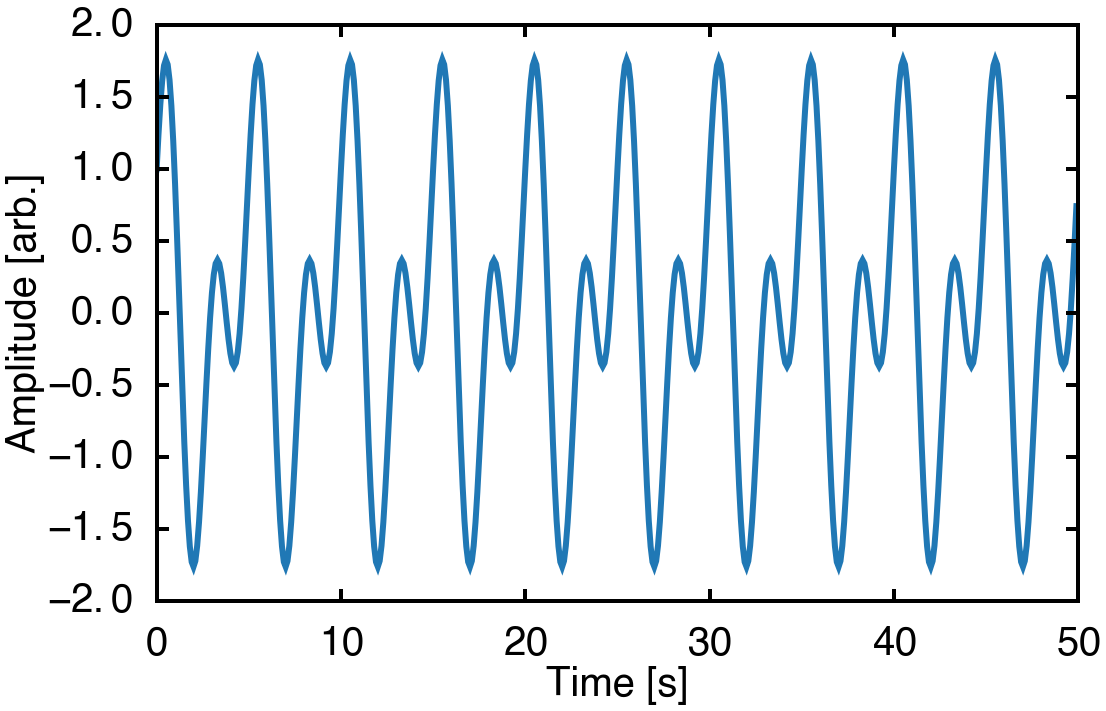

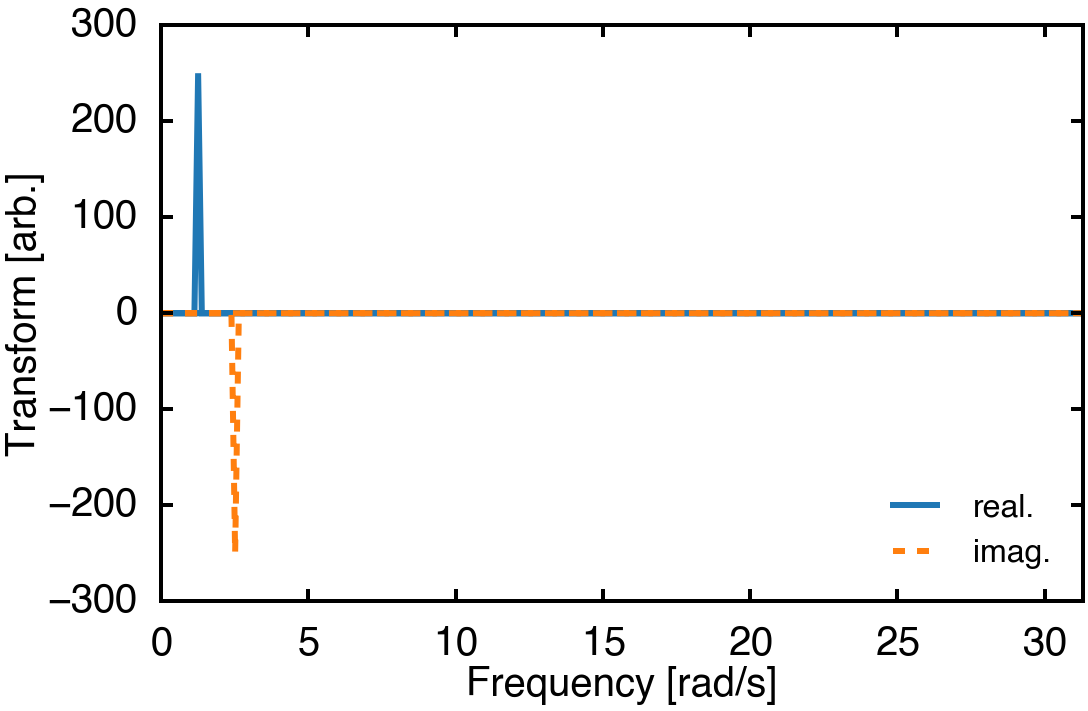

In [103]:
# the time series
Δt = 0.1
t = np.arange(0.0,50.0,Δt)
ω0 = 2.0*π*(0.2)
ϕ = 0.5*π
y = np.sin(ω0*t + ϕ) + np.sin(2*ω0*t)

# Plot the time series
plt.figure(1)
plt.plot(t,y)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [arb.]')

# Get the discrete FT
ω,ŷ = fast_fourier_transform(t,y)

# Plot the real and imaginary parts of the DFT
plt.figure(2)
plt.plot(ω,ŷ.real,label='real.')
plt.plot(ω,ŷ.imag,linestyle='--',label='imag.')
plt.xlim(0,np.max(ω))
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Transform [arb.]')
plt.legend(loc='lower right')

<div class="span alert alert-danger">
np.fft.fft wraps frequencies above the Nyquist frequency to $\omega < 0$.
</div>

### Let's confirm the speedup factor

In [104]:
import timeit
N = np.array([2**n for n in range(6,15)])
dft,fft = [],[]
for cN in N:
    t = np.linspace(0,20,cN)
    y = np.sin(t)
    
    dft.append(timeit.timeit('fourier_transform(t,y)', number=1, globals=globals()))
    fft.append(timeit.timeit('fast_fourier_transform(t,y)', number=1, globals=globals()))
    
dft = np.array(dft)
fft = np.array(fft)

### Try to fit the cuves

In [105]:
from scipy.optimize import curve_fit

def N2(x,*a):
    '''N^2'''
    return a[0] + a[1]*x**2

def NlogN(x,*a):
    '''power function.'''
    return a[0] + a[1]*x*np.log2(x)

# perform the fits
a1,a1_cov = curve_fit(N2,N,dft,p0=(1,1))
a2,a2_cov = curve_fit(NlogN,N,fft,p0=(1,1))

### Plot the results

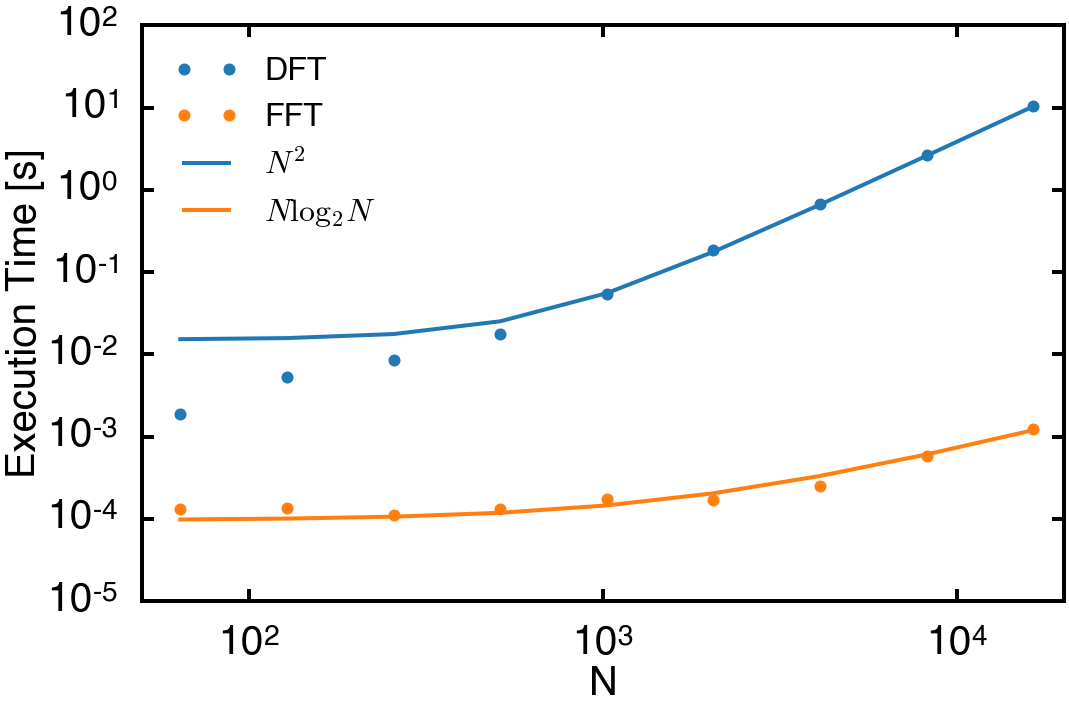

In [106]:
# plot the timing results
plt.loglog(N,dft,'o', markersize=6, mec='None', mfc=colors[0], label='DFT')
plt.loglog(N,fft,'o', markersize=6, mec='None', mfc=colors[1], label='FFT')

# Plot the fits
plt.loglog(N,N2(N,*a1),'-', color=colors[0], zorder=0, linewidth=2, label=r'$N^2$')
plt.loglog(N,NlogN(N,*a2),'-', color=colors[1], zorder=0, linewidth=2, label=r'$N\log_2N$')

plt.xlim(50,20000)
plt.legend(loc='upper left')
plt.xlabel('N')
plt.ylabel('Execution Time [s]')

<div class="span alert alert-success">
<h2> Group Programming challenge </h2>
Revisit the driven dissipative non-linear pendulum and plot the power spectrum for $F_D = 0.5,1.2$.  What does this tell you about the onset/origin of chaos?
</div>

In [110]:
from scipy.constants import g
from scipy.constants import pi as π
def euler(t,FD,ℓ,θ0,ω0,γ,ΩD):
    ''' Semi-implicit Euler Method for the non-linear, dissipative, driven pendulum.'''
    
    Δt = t[1]-t[0]
    ω,θ = np.zeros_like(t),np.zeros_like(t)
    θ[0],ω[0] = θ0,ω0
    
    # perform the numerical integration
    for n in range(t.size-1):
        ω[n+1] = ω[n] + (-(g/ℓ)*np.sin(θ[n]) - γ*ω[n] + FD*np.sin(ΩD*t[n]))*Δt
        θ[n+1] = θ[n] + ω[n+1]*Δt
        
        # keep theta in [-pi,pi)
        if θ[n+1] < -π: θ[n+1] += 2.0*π
        if θ[n+1] >= π: θ[n+1] -= 2.0*π 

    return θ,ω

In [128]:
params = ℓ,θ0,ω0,γ,ΩD = g, 0.2, 0.0, 0.5, 2.0/3.0
FD = [0.5,1.2]
Δt = 0.01

# We determine the maximum time such that N = 2*n
N = int(2**(np.ceil(np.log2(int(500.0/Δt)))))
t = np.arange(0.0,N*Δt,Δt)

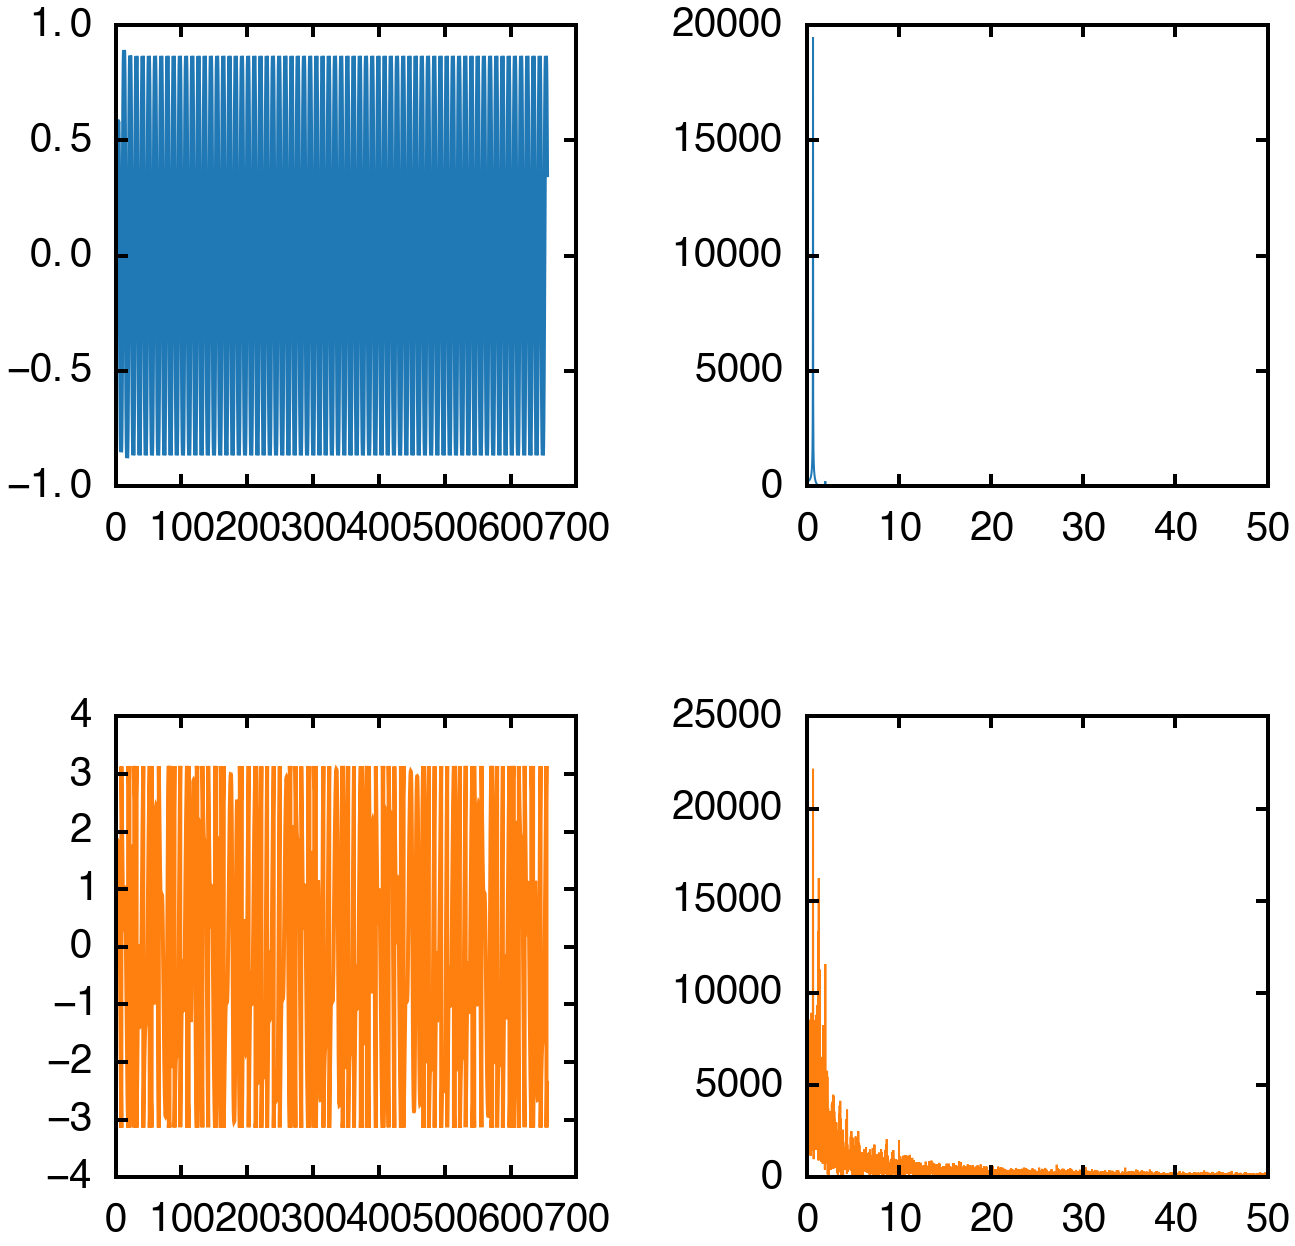

In [129]:
fig, axes = plt.subplots(2,2,sharex=False, sharey=False, figsize=(10,10))
fig.subplots_adjust(wspace=0.5,hspace=0.5)
for i in range(2):
    θ,cω = euler(t,FD[i],*params)
    ω,θ̂ = fast_fourier_transform(t,θ)
    axes[i,0].plot(t,θ,color=colors[i],lw=2)
    axes[i,1].plot(ω,np.abs(θ̂),color=colors[i],lw=1)
    axes[i,1].set_xlim(0,50)
    